In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *

init_logger(save_dir=log_dir)
logger = get_logger()




In [2]:
import numpy as np
A = np.matrix(
    [[1, 1], 
     [3, -4]]
)
e = 0
nmax_iter = 5
retrain_freq=10
x0 = np.array([0, 0])
n_steps = 90
InputDim=2
HiddenDim=100
OutputDim=2

In [3]:
# Initial log message
logger.info("Run with 80 linear problems and train frequency of 10. Function decorator now takes nn parameters as input.")

2020-05-06 10:49:55 [INFO] <ipython-input-3-8142708d9730> 2 - Run with 80 linear problems and train frequency of 10. Function decorator now takes nn parameters as input.


In [4]:
# Set up parameter class
class MyParamsClass():
    def __init__(self, A,nmax_iter,retrain_freq,e,x0,n_steps,InputDim,HiddenDim,OutputDim):
        self.A = A.tolist()
        self.nmax_iter = nmax_iter
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e=e
        self.x0=x0.tolist()
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim

In [5]:
import os
import json

params = MyParamsClass(A,nmax_iter,retrain_freq,e,x0,n_steps,InputDim,HiddenDim,OutputDim)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

In [6]:
from src_dir import *

In [7]:
@nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter):
    return GMRES(A, b, x0, e, nmax_iter)
    

In [8]:
Training_Iterations=np.arange(0,n_steps)

Error0=np.zeros((1,n_steps))
Error1=np.zeros((1,n_steps))
Error2=np.zeros((1,n_steps))
Error0_ML=np.zeros((1,n_steps))
Error1_ML=np.zeros((1,n_steps))
Error2_ML=np.zeros((1,n_steps))


In [9]:
for t in range(n_steps):
    b = np.array([14.*np.random.randn(), 11.*np.random.randn()])  # random b
    Out=MLGMRES(A, b, x0, e, nmax_iter) 
    Error0_ML[:,t]=np.linalg.norm(np.dot(A,Out[0])-b) # Error ML Iteration 1
    Error1_ML[:,t]=np.linalg.norm(np.dot(A,Out[1])-b) # Error ML Iteration 2
    Error2_ML[:,t]=np.linalg.norm(np.dot(A,Out[2])-b) # Error ML Iteration 3
    NonML_Out=GMRES(A, b, x0, e, nmax_iter)
    Error0[:,t]=np.linalg.norm(np.dot(A,NonML_Out[0])-b) # Error GMRES Iteration 1
    Error1[:,t]=np.linalg.norm(np.dot(A,NonML_Out[1])-b) # Error GMRES Iteration 2
    Error2[:,t]=np.linalg.norm(np.dot(A,NonML_Out[2])-b) # Error GMRES Iteration 3

retraining
retraining
retraining
retraining
retraining
retraining
retraining
retraining
retraining


In [10]:

import matplotlib.pyplot as pp

pp.plot(Training_Iterations,np.squeeze(Error0_ML),'r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error0),'k',label='GMRES')
pp.ylabel('Error for 1st GMRES iteration')
pp.xlabel('Linear Problem Iterations')
pp.legend(loc="upper left")
pp.savefig(log_dir+'/Iter0.png')
pp.show()

<Figure size 640x480 with 1 Axes>

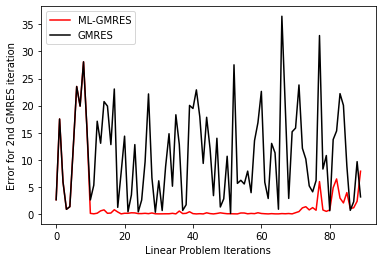

In [11]:
pp.plot(Training_Iterations,np.squeeze(Error1_ML),'r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error1),'k',label='GMRES')
pp.ylabel('Error for 2nd GMRES iteration')
pp.legend(loc="upper left")
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter1.png')
pp.show()

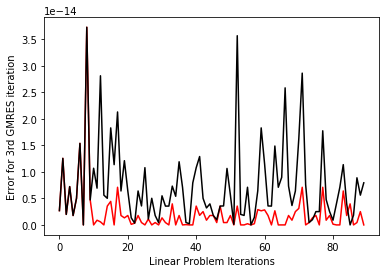

In [12]:
pp.plot(Training_Iterations,np.squeeze(Error2_ML),'r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error2),'k',label='GMRES')
pp.ylabel('Error for 3rd GMRES iteration')
pp.xlabel('Linear Problem Iterations')
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter2.png')
pp.show()

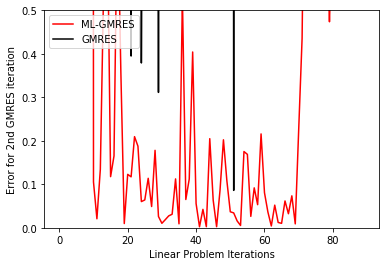

In [13]:
pp.plot(Training_Iterations,np.squeeze(Error1_ML),'r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error1),'k',label='GMRES')
pp.ylabel('Error for 2nd GMRES iteration')
pp.ylim((0, 0.5)) 
pp.legend(loc="upper left")
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter1_zoom.png')
pp.show()

In [14]:
# logger.info("Decreasing learning frquency helps dramatically with overfitting, but it can still be an issue")